## 1. Load image from Google Drive

In [1]:
''' Mount Google Drive '''
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
''' Import libraries '''
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

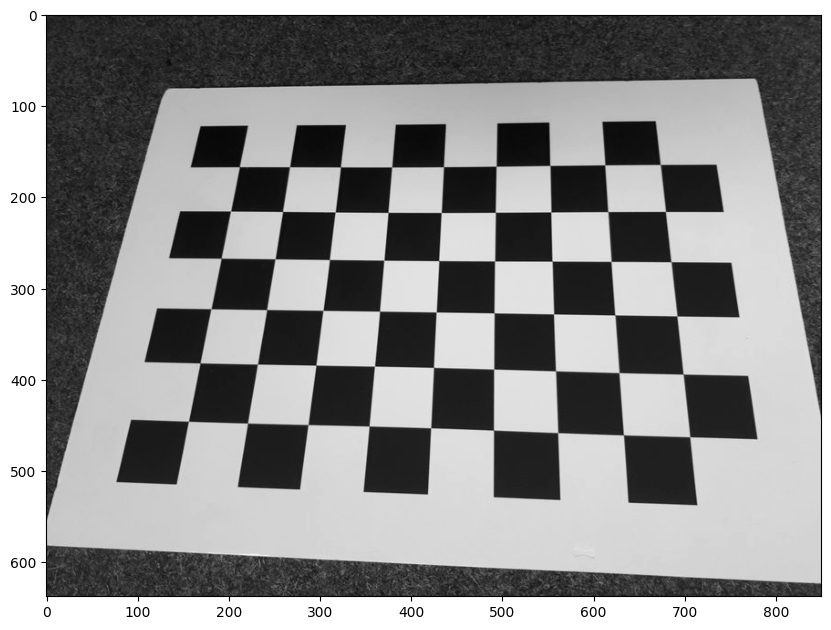

In [3]:
''' Load image using OpenCV '''
# Upload the LMS image to Google Drive and point to its location.
# Note OpenCV reads image as BGR.
img_bgr = cv2.imread("/content/drive/MyDrive/calib_image.png")
# Normalize image to between 0 and 1.
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(float) / 255.0

# Show output
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.show()

## 2. Compute x-derivative (Ix) and y-derivative of image

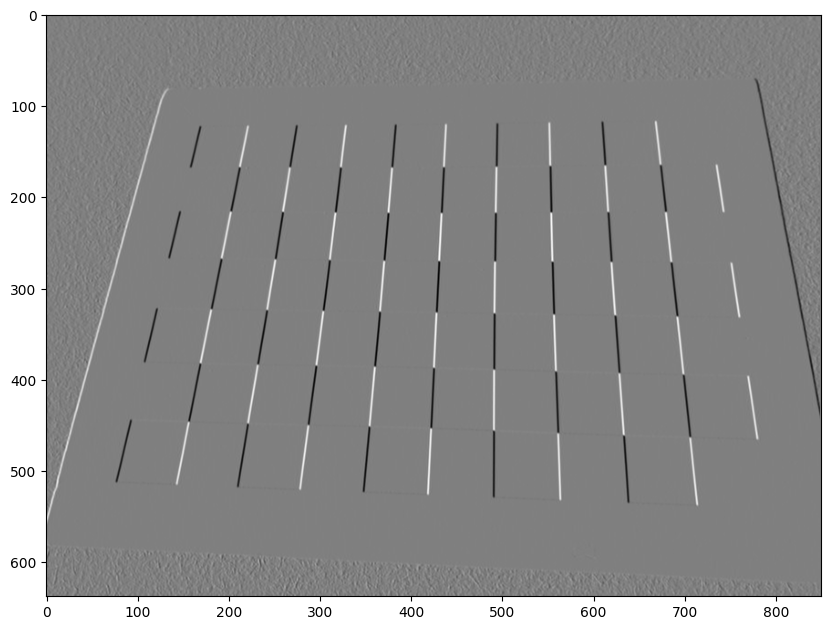

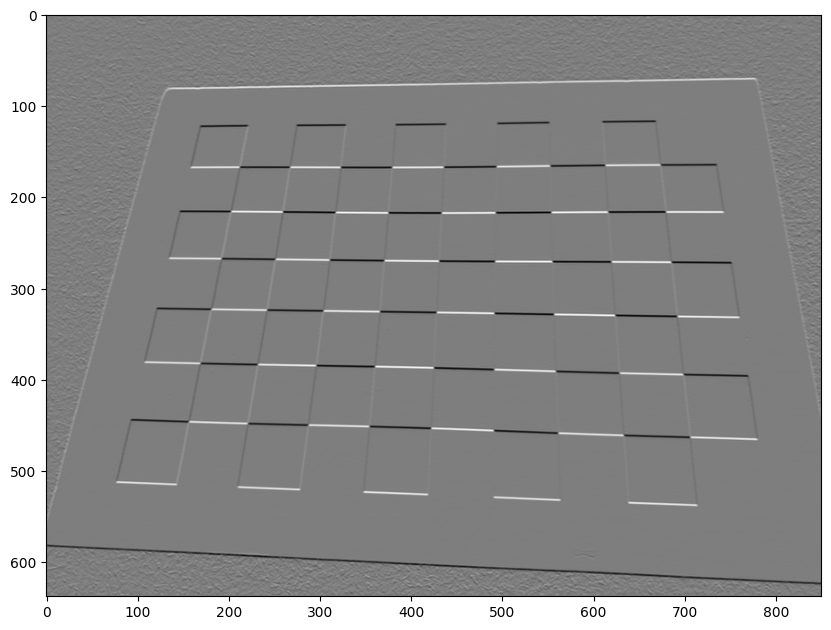

In [4]:
# Perform Sobel filtering along the x-axis.
sobel_x = np.array([[-1/8, 0, 1/8], [-2/8, 0, 2/8], [-1/8, 0, 1/8]]) #takng the difference along the x axis
Ix = cv2.filter2D(img, -1, sobel_x) #gradient respect to x
plt.figure(figsize=(10, 10))
plt.imshow(Ix, cmap='gray') #derivative respect to x
plt.show()

# Perform Sobel filtering along the y-axis.
''' DO IT YOURSELF for sobel_y and Iy '''
sobel_y = np.array([[-1/8, -2/8, -1/8], [0, 0, 0], [1/8, 2/8, 1/8]])
Iy = cv2.filter2D(img, -1, sobel_y)
plt.figure(figsize=(10, 10))
plt.imshow(Iy, cmap='gray') #derivative respect to y
plt.show()

## 3. Compute det(M) and trace(M) around each pixel

In [5]:
''' Approximate local error surface '''
window_size = 3 # E(u,v) through a 3X3 patch
# 전체 image 크기 W x H에서 양쪽 offset=[window_size/2]만큼은 가지못한다. 따라서 E(u, v)의 전체 크기는 (W - 2*offset) x (H - 2*offset)이다.
offset = int(np.floor(window_size/2))

#det is  a matrix containing determinants
det = np.zeros(img.shape)
trace = np.zeros(img.shape)

# For each pixel in image
for y in range(offset, img.shape[0]-offset): #across all y's
  for x in range(offset, img.shape[1]-offset): #across all x's

    # Build ROI window around the current pixel
    # Note numpy uses height-by-width convention (row x column)
    window_x = Ix[y-offset:y+offset+1, x-offset:x+offset+1]
    ''' DO IT YOURSELF for window_y '''
    window_y = Iy[y-offset:y+offset+1, x-offset:x+offset+1]

    # Estimate elements of matrix M.
    Sxx = np.sum(window_x * window_x)
    ''' DO IT YOURSELF for Syy and Sxy '''
    Syy = np.sum(window_y * window_y) #summations of all the gradients within the patch
    Sxy = np.sum(window_x * window_y)

    # Compute determinant of M and trace of M.
    # Note numpy uses height-by-width convention (row x column)
    trace[y,x] = Sxx * Syy
    ''' DO IT YOURSELF for det[y,x] '''
    det[y,x] = Sxx*Syy - Sxy*Sxy

## 4. Compute response around each pixel



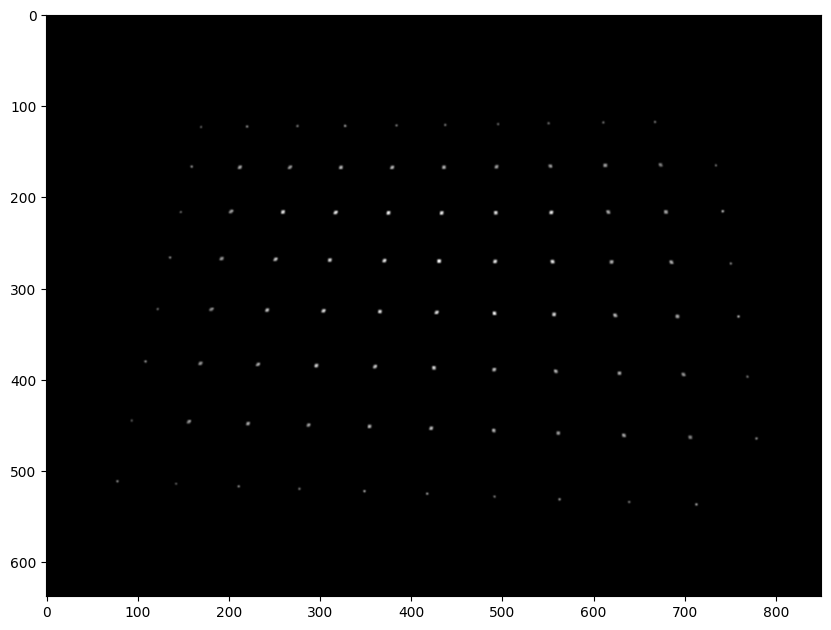

In [6]:
# Set hyperparameters
alpha = 0.05
beta = 0.1

# Compute response map
''' DO IT YOURSELF!: R - det(M) - alpha * trace(M)^2 '''
R = det - alpha * (trace * trace)


# Use thresholding to discard responses with low amplitude
''' DO IT YOURSELF! R is discarded if R < beta * max(R) ''' #R is matrix containg all the response values from all pixels
R[R < beta * np.max(R)] = 0.0

# Smooth the response map using Gaussian filter
''' DO IT YOURSELF! Define gaussian_2d kernel as a numpy array. '''
gaussian_2d = np.array([[1/16, 1/8, 1/16], [1/8, 1/4, 1/8], [1/16, 1/8, 1/16]])
R = cv2.filter2D(R, -1, gaussian_2d)

# Show the response map
plt.figure(figsize=(10, 10))
plt.imshow(R, cmap='gray')
plt.show()


# 5. Perform non-maximal suppression (NMS)

In [7]:
# Set NMS window size
window_size = 3
offset = int(np.floor(window_size/2))

output_img = np.zeros(img.shape)

# For each pixel, perform non-maximal suppression around it in 3x3 block.
for y in range(offset, img.shape[0]-offset):
  for x in range(offset, img.shape[1]-offset):

    if R[y,x] == 0.0:
      # If the response map value is 0, then we can skip
      continue

    center_value = R[y,x]
    ''' DO IT YOURSELF! get max_value of the 3x3 block '''
    max_value = np.max(R[y-offset:y+offset+1, x-offset:x+offset+1])


    # If the center value is not the same as the maximum value of the 3x3 block,
    # then it's not maximum, so suppress.
    # Otherwise, let the pixel survive.
    if center_value != max_value:
      ''' DO IT YOURSELF for output_img[y,x] '''
      output_img[y,x] = 0.0
    else:
      ''' DO IT YOURSELF for output_img[y,x] '''
      output_img[y,x] = 1.0

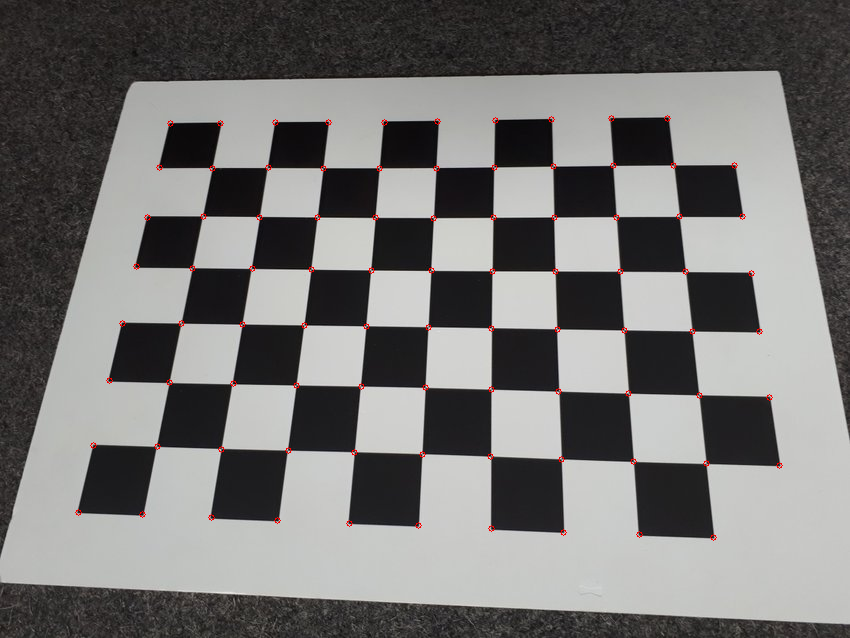

In [8]:
''' Extract feature points and draw on the image '''
y, x = np.where(output_img==1.0)

for i in range(0, len(x)):
  output_vis = cv2.circle(img_bgr, (x[i], y[i]), 3, (0, 0, 255))
cv2_imshow(output_vis)